In [2]:
import numpy as np

import matplotlib.pyplot as plt 
from time import perf_counter_ns

Вычисление $f=u(T,x|q_{exact})$

In [290]:
def solve_pde(q, dx, dt, T): #pde solver for u with eps=0

    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    U = np.zeros((n+1,m+1))
    U[0,:] = q
    for i in range(0,n):
        for j in range(1,m):
            U[i+1,j] = U[i,j] + dt * (U[i,j] * (U[i,j+1] - 2 * U[i,j] + U[i,j-1])/(dx ** 2) + ((U[i,j+1] - U[i,j-1])/(2*dx)) ** 2 + U[i,j] * (1 - U[i,j])) #step for finite differences method
        #boundary conditions
        U[i+1,0] = U[i+1,1]
        U[i+1,m] = U[i+1,m-1]
    U[n,0] = U[n,1]
    U[n,m] = U[n,m-1]

    return U

Реализация метода Ричардсона для вычисления целевого функционала(вычисляем $J(f)$ для улучшения точности до тех пор, пока не достигнем целевой точности,в данном случае $10^{-5}$)

In [291]:
def trap(f, u, dx, eps): #used for evaluating target functional
    m = len(f)
    dt = dx**2/8 * (1+ np.sqrt(dx ** 4 + 16 * eps * dx ** 2))
    s= (f[0]-u[0]) ** 2 + (f[m-1]-u[m-1]) ** 2
    for j in range(1,m-2):
        s += 2 * (f[j]-u[j]) ** 2
    s = s * dx / 2
    return s    

def trap1(A, f, u, dx, eps):
    m = len(f)
    dt = dx**2/8 * (1+ np.sqrt(dx ** 4 + 16 * eps * dx ** 2))
    c=4*trap(f, u, dx, eps)
    d=A
    s=(c-d)/3
    return s



In [323]:
    def func(x):
        return (np.sin(np.pi * x)) ** 2

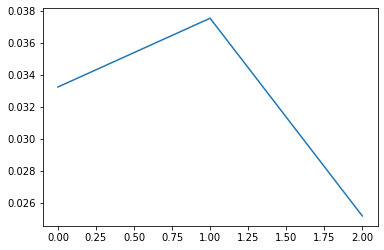

In [385]:
T = 0.01
eps = T / 1000
dx=0.3
dt = dx**2/8 * (1+ np.sqrt(1 + 16 * eps / dx ** 2))
x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)

n = len(t)

m = len(x)
q_ex = np.zeros(m+1)

for i in range(0, m+1):
    q_ex[i] = func(i*dx)
err = 1e-6

cur_diff = 1
Cs = np.zeros(3)
errs = np.zeros(3)

U = solve_pde(q_ex, dx, dt, T)
f = np.zeros(m)
f = U[n,:]
G = solve_pde(f, dx, dt, T)
u = np.zeros(m)
u = G[n,:]
A = trap(f, u, dx, eps)

for s in range(3):
    dx = dx/2
    dt = dx**2/8 * (1+ np.sqrt(1 + 16 * eps / dx ** 2))
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    q_ex = np.zeros(m+1)
    for i in range(0, m+1):
        q_ex[i] = func(i*dx)
    U = solve_pde(q_ex, dx, dt, T)
    f = np.zeros(m)
    f = U[n,:]
    G = solve_pde(f, dx, dt, T)
    u = np.zeros(m)
    u = G[n,:]
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    A1 = trap1(A, q_ex, u, dx, eps)
    curr_diff = np.abs(A1-A)
    A = A1 + (A1-A)/3
    errs[s] = curr_diff

U = solve_pde(q_ex, dx, dt, T)
f = np.zeros(m)
f = U[n,:]

plt.plot(errs)


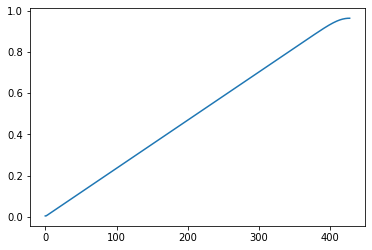

In [318]:
plt.plot(U[n,:])

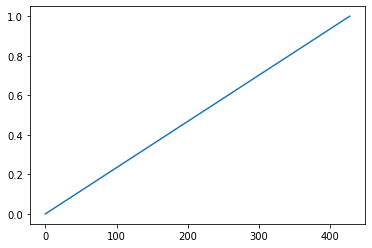

In [319]:
plt.plot(q_ex)

In [272]:
errs[6]

0.01167540674512927

In [386]:
print(dx)

print(dt)

0.0375
0.00036129317104973335


В нашем случае это необходимый размер сетки по $x$ и $t$ соответственно

После этого перейдем к самому градиентному методу: 

In [329]:
def solve_cpde(f, U, dt, dx, T): #conjugate pde solver for p --- time-inverted conjugate pde
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    P = np.zeros((n+1,m+1))
    P[0,:] = 2 * (f - U[n, :])
    for i in range(0,n):
        P[i+1,0] = P[i+1,1]
        P[i+1,m] = P[i+1,m-1]
        for j in range(1,m):
            P[i+1,j] = P[i,j] + dt * (P[n-i,j] * (P[i,j+1] - 2 * P[i,j] + P[i,j-1])/(dx ** 2) - (2 * U[n-i,j] - 1) * P[i,j])
    P[n,0] = P[n,1]
    P[n,m] = P[n,m-1]
    return P  

In [330]:
def error(f, U, dx):
    s = 0
    for j in range(m+1):
        s = s + dx * (f[j] - U[n,j]) ** 2
    return s

In [399]:
def solve_pde_m(q, dx, dt, T, e): #pde solver for u with eps
    if (e == 0):
        return solve_pde(q, dx, dt, T)
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    U = np.zeros((n+1,m+1))
    U[0,:] = q
    U[1,:] = q
    for i in range(1,n):
        for j in range(1,m):
            U[i+1,j] = (2*e*U[i,j]/(dt ** 2) -e*U[i-1,j]/(dt ** 2) + U[i,j] / dt + U[i,j] * (U[i,j+1] - 2 * U[i,j] + U[i,j-1])/(dx ** 2) + ((U[i,j+1] - U[i,j])/(dx)) * ((U[i,j+1] - U[i,j-1])/(2*dx)) + U[i,j] * (1-U[i,j]))*(2 * dt * dt)/(e+dt) #step for finite differences method
        #boundary conditions
        U[i+1,0] = U[i+1,1]
        U[i+1,m] = U[i+1,m-1]
    U[n,0] = U[n,1]
    U[n,m] = U[n,m-1]

    return U

In [400]:
def solve_cpde_m(f, U, dt, dx, T, e): #conjugate pde solver for p --- time-inverted conjugate pde with eu_tt
    if (e == 0):
        return solve_cpde(f, U, dt, dx, T)
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    n = len(t)
    m = len(x)
    P = np.zeros((n+1,m+1))
    P[1,:] = 2 * (f - U[n, :]) * dt / e
    for i in range(1,n):
        for j in range(1,m):
            P[i+1,j] = (2*e*P[i,j]/(dt ** 2) -e*P[i-1,j]/(dt ** 2) + P[i,j]/dt  + U[n-i,j] * (P[i,j+1] - 2 * P[i,j] + P[i,j-1])/(dx ** 2) + (1 - 2 * U[n-i,j])* P[i,j])*(2 * dt * dt)/(e+dt)
        P[i+1,0] = P[i+1,1]
        P[i+1,m] = P[i+1,m-1]
    P[n,0] = P[n,1]
    P[n,m] = P[n,m-1]
    return P  


In [442]:
T=0.01

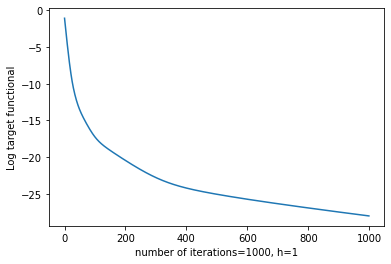

Time elapsed:  4.396428  seconds


In [443]:
#gradient method for eps = 0
#for given q_ex
def exact_init(x):
    return (np.sin(np.pi * x)) ** 2 #set yourself

x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)
n = len(t)
m = len(x)
U = np.zeros((n+1,m+1))
e = 0
P = np.zeros((n+1,m+1))
h = 0.1#set yourself

q = np.zeros(m+1)
n_iter = 1000#set yourself
for i in range(m+1):
    q_ex[i] = exact_init(dx*i)

U = solve_pde_m(q_ex, dx, dt, T, e) #calculating U(t,x|q_ex)
f = U[n,:]

r = np.zeros(n_iter)
grad = np.zeros(m) 
x = np.zeros(n_iter)
for j in range(n_iter):
    time_before = perf_counter_ns()
    P = np.zeros((n+1,m+1))
    U = solve_pde_m(q, dx, dt, T, e) #calculating U(t,x|q)
    P = solve_cpde_m(f, U, dt, dx, T, e)
    grad =  - P[n, :] - e * (P[n,:] - P[n-2,:])/(2*dt) #current grad
    for k in range(m):
        q[k] = q[k] - h * grad[k]
    r[j] = np.log(error(f, U, dx))
    x[j] = j
time_taken = (perf_counter_ns() - time_before) * 1e-6


fig, ax = plt.subplots()
ax.plot(x, r)
ax.set_xlabel('number of iterations=1000, h=1')
ax.set_ylabel('Log target functional')
plt.show()
print('Time elapsed: ', time_taken, ' seconds')

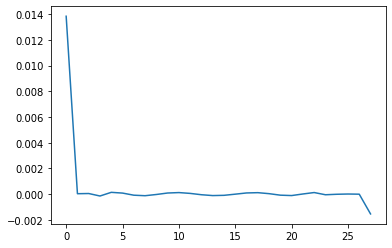

In [444]:
plt.plot(q-q_ex)

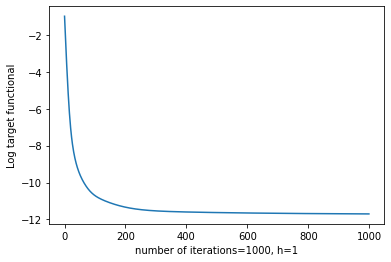

Time elapsed:  9.322224  seconds


In [445]:
#gradient method for eps = 0
#for unknown q_ex given f(x)
x = np.arange(0, 1, dx)
t = np.arange(0, T, dt)
n = len(t)
m = len(x)
U = np.zeros((n+1,m+1))
e = 0
P = np.zeros((n+1,m+1))
h = 0.1#set yourself

q = np.zeros(m+1)
n_iter = 1000 #set yourself
for i in range(m+1):
    f[i] = func(dx*i)
r = np.zeros(n_iter)
grad = np.zeros(m) 
x = np.zeros(n_iter)
for j in range(n_iter):
    time_before = perf_counter_ns()
    P = np.zeros((n+1,m+1))
    U = solve_pde_m(q, dx, dt, T, e) #calculating U(t,x|q)
    P = solve_cpde_m(f, U, dt, dx, T, e)
    grad =  - P[n, :] - e * (P[n,:] - P[n-2,:])/(2*dt) #current grad
    for k in range(m):
        q[k] = q[k] - h * grad[k]
    r[j] = np.log(error(f, U, dx))
    x[j] = j
time_taken = (perf_counter_ns() - time_before) * 1e-6


fig, ax = plt.subplots()
ax.plot(x, r)
ax.set_xlabel('number of iterations=1000, h=1')
ax.set_ylabel('Log target functional')
plt.show()
print('Time elapsed: ', time_taken, ' seconds')